### EEG Preprocessing with MNE

In [2]:
%matplotlib inline
import os
import os.path as op
import mne
import numpy as np
import pandas as pd

### 1. Importing Raw  Data

In [3]:
examples_dir = 'D:\\FY2025\\Fukuyama\\work place\\aging prog\\data\\EEG_MPILMBB_LEMON\\EEG_Raw_BIDS_ID\\sub-010002\\RSEEG\\sub-010002.eeg'   # Path to the raw EEG Data folder
vhdr_file = op.join(examples_dir, 'D:\\FY2025\\Fukuyama\\work place\\aging prog\\data\\EEG_MPILMBB_LEMON\\EEG_Raw_BIDS_ID\\sub-010002\\RSEEG\\sub-010002.vhdr')                # Path to the raw EEG header file
raw = mne.io.read_raw_brainvision(vhdr_file, misc='auto')        # Returns a Raw object containing BrainVision data
raw.load_data()                                                   # Loading continuous data

Extracting parameters from D:\FY2025\Fukuyama\work place\aging prog\data\EEG_MPILMBB_LEMON\EEG_Raw_BIDS_ID\sub-010002\RSEEG\sub-010002.vhdr...
Setting channel info structure...
Reading 0 ... 2554999  =      0.000 ...  1022.000 secs...


<RawBrainVision | sub-010002.eeg, 62 x 2555000 (1022.0 s), ~1.18 GiB, data loaded>

In [4]:
#Downsampling
#raw.resample(256, npad="auto")    # set sampling frequency to 256 points per second

In [31]:
montage = mne.channels.make_standard_montage('standard_1020')  # 例：BioSemiなら 'biosemi64'
raw.set_montage(montage)

ValueError: DigMontage is only a subset of info. There is 1 channel position not present in the DigMontage. The channel missing from the montage is:

['VEOG'].

Consider using inst.rename_channels to match the montage nomenclature, or inst.set_channel_types if this is not an EEG channel, or use the on_missing parameter if the channel position is allowed to be unknown in your analyses.

### 2. Filtering the data

In [5]:
#raw.filter(1, 45, fir_design='firwin', picks=['eeg'])  # band-pass filter from 1 to 45 frequency over just
                                                        # EEG channel

# Define IIR filter parameters: 8th-order Butterworth filter
iir_params = dict(order=8, ftype='butter')

# Apply a band-pass filter from 1 to 45 Hz using zero-phase filtering
raw_filtered = raw.copy().filter(
    l_freq=1.,              # Lower cutoff frequency (Hz)
    h_freq=45.,             # Upper cutoff frequency (Hz)
    method='iir',           # Use IIR filtering
    iir_params=iir_params,  # Specify filter order and type
    phase='zero',           # Apply zero-phase (forward-backward) filtering to avoid phase distortion
    verbose=True            # Print filtering information
)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 32 (effective, after forward-backward)
- Cutoffs at 1.00, 45.00 Hz: -6.02, -6.02 dB



In [33]:
# Show a short segment of the original raw EEG (before splitting)
raw_filtered.plot(title='Original raw EEG (before block splitting)', duration=20, start=0)

### 3. Divided into EO conditions and EC conditions

In [ ]:
# 1. Extract events and event_id dictionary from annotations in the raw data
events, event_id = mne.events_from_annotations(raw_filtered)
print(events[:50])
print(event_id)

Used Annotations descriptions: [np.str_('Comment/no USB Connection to actiCAP'), np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S200'), np.str_('Stimulus/S210')]
[[     0      0  99999]
 [     0      0  10001]
 [  9979      0      1]
 [ 15938      0      1]
 [ 15962      0    210]
 [ 20962      0    210]
 [ 25962      0    210]
 [ 30962      0    210]
 [ 35962      0    210]
 [ 40962      0    210]
 [ 45962      0    210]
 [ 50962      0    210]
 [ 55962      0    210]
 [ 60962      0    210]
 [ 65963      0    210]
 [ 70963      0    210]
 [ 75963      0    210]
 [ 80963      0    210]
 [ 85963      0    210]
 [ 90963      0    210]
 [ 95963      0    210]
 [100963      0    210]
 [105963      0    210]
 [110963      0    210]
 [115963      0    210]
 [120963      0    210]
 [125964      0    210]
 [130964      0    210]
 [135964      0    210]
 [140964      0    210]
 [145964      0    210]
 [150964      0    210]
 [155964      0    210]
 [160964      0    210]


Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none


In [ ]:
event_id.get('Stimulus/S210', -1)

210

In [ ]:
fs = int(raw_filtered.info['sfreq'])

eo_blocks = []
ec_blocks = []

# Get numeric event codes
eo_code = event_id.get('Stimulus/S200', -1)  # Eyes Open
ec_code = event_id.get('Stimulus/S210', -1)  # Eyes Closed

for i, event in enumerate(events[:-1]):  # skip last (no next)
    this_sample = event[0]
    this_code = event[2]
    
    next_sample = events[i + 1][0]
    next_code = events[i + 1][2]

    t_start = this_sample / fs
    t_end = next_sample / fs

    # Only include block if the same condition continues (no switch)
    if this_code == eo_code and next_code == eo_code:
        eo_blocks.append(raw_filtered.copy().crop(tmin=t_start, tmax=t_end, include_tmax=False))
    elif this_code == ec_code and next_code == ec_code:
        ec_blocks.append(raw_filtered.copy().crop(tmin=t_start, tmax=t_end, include_tmax=False))
    # Transitions (e.g., EO → EC or EC → EO) are skipped


In [12]:
# Concatenate all blocks
raw_eo = mne.concatenate_raws(eo_blocks) if eo_blocks else None
raw_ec = mne.concatenate_raws(ec_blocks) if ec_blocks else None

### 4. Rereference

In [21]:
raw_ec.set_eeg_reference('average', projection=True).apply_proj()  # re-referencing with the virtual average reference
raw_eo.set_eeg_reference('average', projection=True).apply_proj()

EEG channel type selected for re-referencing
Projections have already been applied. Setting proj attribute to True.
EEG channel type selected for re-referencing
Projections have already been applied. Setting proj attribute to True.


C:\Users\sFukuyama\AppData\Local\Temp\7\ipykernel_43592\4101743857.py:1: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw_ec.set_eeg_reference('average', projection=True).apply_proj()  # re-referencing with the virtual average reference
C:\Users\sFukuyama\AppData\Local\Temp\7\ipykernel_43592\4101743857.py:2: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw_eo.set_eeg_reference('average', projection=True).apply_proj()


<RawBrainVision | sub-010002.eeg, 62 x 1160017 (464.0 s), ~548.8 MiB, data loaded>

In [ ]:
#eo_fname = 'D:\\FY2025\\Fukuyama\\work place\\original_preprocessed_data\\sub-010002\\sub-010002_EO.fif'
#ec_fname = 'D:\\FY2025\\Fukuyama\\work place\\original_preprocessed_data\\sub-010002\\sub-010002_EC.fif'

# Load raw data from FIF files
#raw_eo = mne.io.read_raw_fif(eo_fname, preload=True)
#raw_ec = mne.io.read_raw_fif(ec_fname, preload=True)

In [13]:
# Plot EC condition (eyes closed)
raw_ec.plot(title='Eyes Closed (EC)', duration=20, start=0)

In [16]:
events_ec, event_id_ec = mne.events_from_annotations(raw_ec)
print(events_ec)

Used Annotations descriptions: [np.str_('Stimulus/S210')]
[[  15962       0     210]
 [  20962       0     210]
 [  20962       0     210]
 ...
 [1170979       0     210]
 [1170979       0     210]
 [1175979       0     210]]


In [32]:
# Plot EO condition (eyes open)
raw_eo.plot(title='Eyes Open (EO)', duration=20, start=0)

In [15]:
events_eo, event_id_eo = mne.events_from_annotations(raw_eo)
print(events_eo)

Used Annotations descriptions: [np.str_('Stimulus/S200')]
[[ 171871       0     200]
 [ 176871       0     200]
 [ 176871       0     200]
 ...
 [1326888       0     200]
 [1326888       0     200]
 [1331888       0     200]]


In [17]:
duration_eo = raw_eo.times[-1]
duration_ec = raw_ec.times[-1]

print(f"Eyes Open (EO) duration: {duration_eo:.2f} sec")
print(f"Eyes Closed (EC) duration: {duration_ec:.2f} sec")

Eyes Open (EO) duration: 464.01 sec
Eyes Closed (EC) duration: 464.01 sec


In [18]:
# Specify file names for saving
eo_fname = 'D:\\FY2025\\Fukuyama\\work place\\original_preprocessed_data\\sub-010002\\sub-010002_EO.fif'
ec_fname = 'D:\\FY2025\\Fukuyama\\work place\\original_preprocessed_data\\sub-010002\\sub-010002_EC.fif'

# Save the segmented raw data to FIF files
# overwrite=True allows overwriting if files already exist
raw_eo.save(eo_fname, overwrite=True)
raw_ec.save(ec_fname, overwrite=True)

Writing D:\FY2025\Fukuyama\work place\original_preprocessed_data\sub-010002\sub-010002_EO.fif


C:\Users\sFukuyama\AppData\Local\Temp\7\ipykernel_43592\1578394879.py:7: RuntimeWarning: This filename (D:\FY2025\Fukuyama\work place\original_preprocessed_data\sub-010002\sub-010002_EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_eo.save(eo_fname, overwrite=True)


Closing D:\FY2025\Fukuyama\work place\original_preprocessed_data\sub-010002\sub-010002_EO.fif
[done]
Writing D:\FY2025\Fukuyama\work place\original_preprocessed_data\sub-010002\sub-010002_EC.fif


C:\Users\sFukuyama\AppData\Local\Temp\7\ipykernel_43592\1578394879.py:8: RuntimeWarning: This filename (D:\FY2025\Fukuyama\work place\original_preprocessed_data\sub-010002\sub-010002_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_ec.save(ec_fname, overwrite=True)


Closing D:\FY2025\Fukuyama\work place\original_preprocessed_data\sub-010002\sub-010002_EC.fif
[done]


[WindowsPath('D:/FY2025/Fukuyama/work place/original_preprocessed_data/sub-010002/sub-010002_EC.fif')]

Channels marked as bad:
none
Channels marked as bad:
none


### 5. Visual Inspection

###### 5.1 Plot continuous data

In [26]:
%matplotlib qt
raw_ec.plot()       # plot the EEG data. Use the '%matplotlib qt' to see 
                    # the data in a bright way and move conveniently

Channels marked as bad:
none


###### 5.2 channel bad correction

In [27]:
raw_eo.plot()

Channels marked as bad:
none


In [ ]:
#raw.info['bads'] = ['Fp1','Fp2','Fpz']         # Select bad channels visually to interpolate them with channels
                                               # Sleceted channels are not real
#raw = raw.interpolate_bads(reset_bads=False)

ValueError: bad channel(s) ['Fpz'] marked do not exist in info

Channels marked as bad:
none


### 6. Independent Component Analysis  (ICA)

In [26]:
from mne.preprocessing import ICA

# 1. Set parameters for ICA
n_components = 20        # 抽出する独立成分数。データの次元や目的に合わせて調整
method = 'fastica'       # ICAアルゴリズム（fastica, infomaxなど）
random_state = 97        # 再現性確保のため乱数シードを固定

# 2. ICAオブジェクトの作成
ica = ICA(n_components=n_components, method=method, random_state=random_state)

# 3. ICAの適用（フィッティング）
ica.fit(raw_ec)

Fitting ICA to data using 62 channels (please be patient, this may take a while)
    Applying projection operator with 1 vector (pre-whitener computation)
    Applying projection operator with 1 vector (pre-whitener application)
Selecting by number: 20 components
    Applying projection operator with 1 vector (pre-whitener application)
Fitting ICA took 29.9s.


Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,46 iterations on raw data (1160017 samples)
ICA components,20
Available PCA components,62
Channel types,eeg
ICA components marked for exclusion,—


###### 7.2 ICA run

In [ ]:
%matplotlib inline
# %matplotlib qt
raw_ec.set_montage('standard_1020')
ica.plot_components()  # Plot all decomposed components

ValueError: DigMontage is only a subset of info. There is 1 channel position not present in the DigMontage. The channel missing from the montage is:

['VEOG'].

Consider using inst.rename_channels to match the montage nomenclature, or inst.set_channel_types if this is not an EEG channel, or use the on_missing parameter if the channel position is allowed to be unknown in your analyses.

... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 s

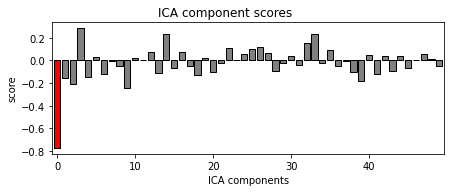

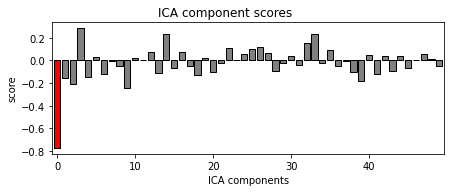

In [45]:
ica.exclude = []                                    # to save list of EOG comonents
eog_indices, eog_scores = ica.find_bads_eog(raw)    # Detect EOG related components using correlation
                                                    # Return the indices of EOG related components, sorted by score
ica.exclude = eog_indices
ica.plot_scores(eog_scores)                          # Barplot of ICA component "EOG match" scores
if len(eog_indices)>0:
    ica.plot_properties(epochs, picks=eog_indices)   # plot diagnostics
    ica.plot_sources(epochs)                         # plot ICs applied to raw data, with EOG matches highlighted
    ica.plot_sources(eog_evoked)                     # plot ICs applied to the averaged EOG epochs,
                                                     # with EOG matches highlighted

In [42]:
ica.exclude

[0]

###### 7.4 EOG component rejection automatically

Using channel ECG to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 2560 samples (10.000 sec)



<ipython-input-46-5a87a7d41ef7>:2: DeprecationWarning: The default for "threshold" will change from None to"auto" in version 0.22. To avoid this warning, explicitly set threshold to "auto".
  ecg_indices, ecg_scores = ica.find_bads_ecg(raw, method='ctps') # Detect EOCG related components using correlation


Number of ECG events detected : 1670 (average pulse 81 / min.)
Not setting metadata
Not setting metadata
1670 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 1670 events and 257 original time points ...
0 bad epochs dropped


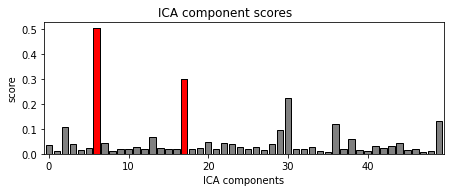

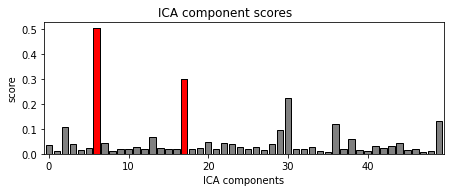

In [46]:
ica.exclude = []                                                # to save list of EOG comonents#
ecg_indices, ecg_scores = ica.find_bads_ecg(raw, method='ctps') # Detect EOCG related components using correlation
                                                                # Return the indices of ECG related components, sorted by score
ica.exclude = ecg_indices
ica.plot_scores(ecg_scores)                                     # barplot of ICA component "ECG match" scores
if len(ecg_indices)>0:
    ica.plot_properties(epochs, picks=ecg_indices)              # plot diagnostics
    ica.plot_sources(epochs)                                    # plot ICs applied to raw data, with ECG matches highlighted
    ica.plot_sources(ecg_evoked)                                # plot ICs applied to the averaged ECG epochs, 
                                                                # with ECG matches highlighted

In [44]:
ica.exclude

[6, 17]

###### 7.5 Reconstruction of EEG data

In [ ]:
ica.exclude = [11, 26, 29, 30, 33, 34, 35, 36, 38, 44, 48, 49, 0, 6, 17] 
                                        # Put all comonent which you want to remove containg inspected (manual) 
                                        # [11, 26, 29, 30, 33, 34, 35, 36, 38, 44, 48, 49], EOG [0] and ECG [6,17] components
                                        # Selected components are not real
ica.apply(epochs)                       # Channels can be reconstructed using the ICA object’s apply()

<div class="alert alert-block alert-info">
<b>Tip:</b> Exprimentally, I try not to remove more than 30% of the total independent components
</div>

### 8. Save preprocessed EEG data  

In [ ]:
epochs.save(examples_dir + "\\sub-006_prerprocessed.fif")